## Setup

make sure you run the setup file and put the input path for netcdf's and output path for the zarr store in your .env

In [1]:
import time
import os
import xarray as xr
import zarr
from dotenv import load_dotenv
import os
import subprocess

# Load environment variables from the .env file
load_dotenv()

# Get the directory paths from the environment variables
input_directory = os.getenv("INPUT_NCDF_DIRECTORY")
output_zarr_store = os.getenv("OUTPUT_ZARR_STORE")

# Expand the tilde to the full path
input_directory = os.path.expanduser(input_directory)
output_zarr_store = os.path.expanduser(output_zarr_store)

print(f"Input Directory: {input_directory}")
print(f"Output Zarr Store: {output_zarr_store}")

Input Directory: /home/thom/Desktop/CIPM/FruitFlyPheno/data/test/PRISM/
Output Zarr Store: /home/thom/Desktop/CIPM/FruitFlyPheno/data/zarr/


## create Zarr store

 the benefit of moving to a zarr database instead of using separate netcdf's is speed - Zarr stores data as binary chunks of lat/lon/time and keeps a lookup table of a particlar x/y/z position for data on hand. Thus, when you query some 3D cube of data, Zarr opens only the relevant binary chunk and decodes it. This differs from the current NetCDF implementation which decodes the whole CONUS daily file before extracting the lat/lon desired. 

 In addition to being much faster than the current scheme, the Zarr implementation is also  more space efficient.
 

In [2]:
# Zarr stores Chunking Schemes
# there are different chunking schemes that can be used to store the data in the zarr store.
# my application requires data for small spatial regions with a large number of time steps.
fflies_chunking = {"t": 1000, "latitude": 10, "longitude": 10}
# this generic chunking scheme might me more suitable for other applications using larger spatial regions and fewer time steps
generic_chunking = {"t": 100, "lat": 100, "lon": 100}
# the final chunking scheme will need to be tested once we have a production system in place

In [3]:
# Function to convert NetCDF files in a directory to a Zarr store
def convert_netcdf_to_zarr(input_directory, output_zarr_store):
    # List all .nc files in the input directory
    netcdf_files = []
    for root, dirs, files in os.walk(input_directory):
        for file in files:
            if file.endswith(".nc"):
                netcdf_files.append(os.path.join(root, file))

        # Save the combined dataset to a Zarr store
    print("scanning")
    try:
        datasets = [
            xr.open_dataset(nc_file)  # if error, try installing netCDF4 from conda
            for nc_file in netcdf_files[:50]
        ]  # Limiting to 50 files for testing
    except ValueError:
        print(datasets[:0])
        print(
            "ValueError: Unable to open the NetCDF files. Please check the files - sometimes partial downloads appear or some netcdfs are inexplicably broken :( "
        )
        return
    print("finished opening datasets")
    combined_dataset = xr.concat(datasets, dim="t")
    print("finished concatenating datasets")
    # combined_dataset = combined_dataset.chunk(fflies_chunking) breaks during read in?
    print(combined_dataset)
    print("finished chunking")

    combined_dataset.to_zarr(
        output_zarr_store,
        mode="w",
    )


# Define the input directory and output Zarr store


convert_netcdf_to_zarr(input_directory, output_zarr_store)

scanning
finished opening datasets
finished concatenating datasets
<xarray.Dataset> Size: 1GB
Dimensions:    (t: 50, latitude: 621, longitude: 1405)
Coordinates:
  * t          (t) datetime64[ns] 400B 2001-01-07 2001-01-03 ... 2019-01-04
  * longitude  (longitude) float64 11kB -125.0 -125.0 -124.9 ... -66.54 -66.5
  * latitude   (latitude) float64 5kB 49.92 49.88 49.83 ... 24.17 24.12 24.08
Data variables:
    ppt        (t, latitude, longitude) float64 349MB -3.4e+38 -3.4e+38 ... nan
    tmean      (t, latitude, longitude) float64 349MB nan nan nan ... nan nan
    tmin       (t, latitude, longitude) float64 349MB nan nan nan ... nan nan
    tmax       (t, latitude, longitude) float64 349MB nan nan nan ... nan nan
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t
finished chunking


## read zarr store
now we can play around with the zarr store to check out some functionality

In [4]:
data = xr.open_zarr(output_zarr_store)
data.chunks

Frozen({'t': (7, 7, 7, 7, 7, 7, 7, 1), 'latitude': (78, 78, 78, 78, 78, 78, 78, 75), 'longitude': (352, 352, 352, 349)})

Time taken to read the data: 8.511543273925781e-05 seconds


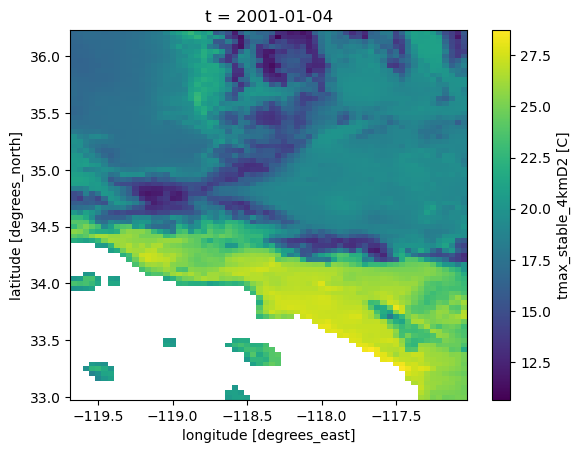

In [6]:
lat_min, lat_max = 36.23115, 33.0  # Example latitude range
lon_min, lon_max = -119.7, -117  # Example longitude range
time_start, time_end = "2000-01-01", "2023-01-31"  # Example time range
# Subset the dataset by latitude, longitude, and time
subset = data.sel(
    latitude=slice(lat_min, lat_max),
    longitude=slice(lon_min, lon_max),
    # t=slice(time_start, time_end),
)

# Select only the variables 'tmin' and 'tmax'
subset = subset[["tmin", "tmax"]]
start_time = time.time()
dat = subset.values
end_time = time.time()
print(f"Time taken to read the data: {end_time - start_time} seconds")
subset["tmax"].isel(t=5).plot()
# import xpublish

# rest = xpublish.SingleDatasetRest(data)

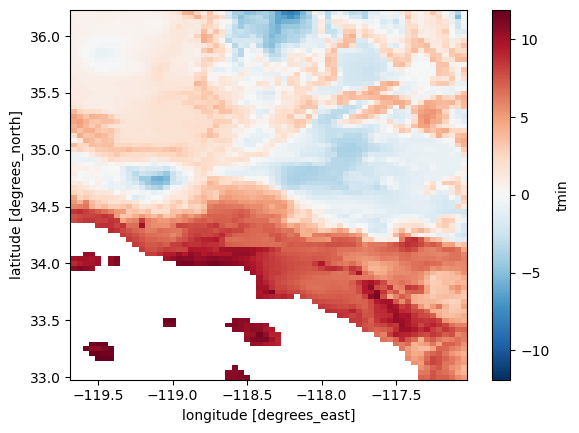

In [7]:
# or we can aggregate the data - mean minimum temperature throughout the time period
subset["tmin"].mean(dim="t").plot()

# Updating the Zarr store
we get a new daily netcdf - it's fairly easy to add this into the zarr store. 


In [20]:
netcdf_files = []
for root, dirs, files in os.walk(input_directory):
    for file in files:
        if file.endswith(".nc"):
            netcdf_files.append(os.path.join(root, file))


new_netcdf = xr.open_dataset(
    netcdf_files[54]
)  # we previously opened the first 50 files, now we open the 51st file to simulate a new file being added to the directory -
# maybe we could set up a watch on the directory to trigger updating when a new file is added

In [21]:
new_netcdf

<xarray.Dataset> Size: 28MB
Dimensions:    (t: 1, longitude: 1405, latitude: 621)
Coordinates:
  * t          (t) datetime64[ns] 8B 2017-01-04
  * longitude  (longitude) float64 11kB -125.0 -125.0 -124.9 ... -66.54 -66.5
  * latitude   (latitude) float64 5kB 49.92 49.88 49.83 ... 24.17 24.12 24.08
Data variables:
    ppt        (t, latitude, longitude) float64 7MB ...
    tmean      (t, latitude, longitude) float64 7MB ...
    tmin       (t, latitude, longitude) float64 7MB ...
    tmax       (t, latitude, longitude) float64 7MB ...
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t

In [22]:
new_netcdf.to_zarr(output_zarr_store, append_dim="t")
# appening takes just a little longer than writing the first time - this is because the metadata needs to be updated

# Serving Zarr
please make sure you try the setup notebook first, to make sure xpublish is working correctly.

Once it is, navigate to the terminal and run "python xpublish_test.py"

In [4]:
import zarr
from fsspec.implementations.http import HTTPFileSystem
import xarray as xr

fs = HTTPFileSystem()

# The URL 'http://0.0.0.0:9000/zarr/' here serves one dataset
http_map = fs.get_mapper("http://0.0.0.0:8000/zarr/")

# open as a zarr group

# or open as another Xarray Dataset
ds = xr.open_zarr(http_map, consolidated=True)

ClientResponseError: 500, message='Internal Server Error', url='http://0.0.0.0:8000/zarr/.zmetadata'

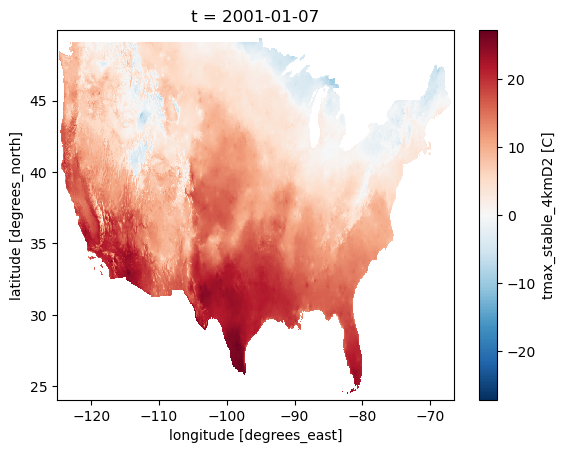

In [3]:
ds["tmax"].isel(t=0).plot()